In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # EarlyStopping during model training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import warnings

sns.set_theme(style="darkgrid")
warnings.simplefilter('ignore', np.RankWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btc-daily-1/BTC-USD (1).csv
/kaggle/input/btcinusd/BTC-2019min.csv
/kaggle/input/btcinusd/BTC-Hourly.csv
/kaggle/input/btcinusd/BTC-Daily.csv
/kaggle/input/btcinusd/BTC-2020min.csv
/kaggle/input/btcinusd/BTC-2017min.csv
/kaggle/input/btcinusd/BTC-2018min.csv
/kaggle/input/btcinusd/BTC-2021min.csv


# Getting the Data and evaluating it.

In [41]:
df = pd.read_csv("/kaggle/input/btcinusd/BTC-Hourly.csv", index_col='date', parse_dates=True)

In [42]:
df = df.drop(['unix', 'symbol'], axis=1)
df = df.sort_index(ascending=True)
df.head()

,open,high,low,close,Volume BTC,Volume USD
date,,,,,,
2018-05-15 06:00:00,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
2018-05-15 07:00:00,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
2018-05-15 08:00:00,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
2018-05-15 09:00:00,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
2018-05-15 10:00:00,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33259 entries, 2018-05-15 06:00:00 to 2022-03-01 00:00:00
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        33259 non-null  float64
 1   high        33259 non-null  float64
 2   low         33259 non-null  float64
 3   close       33259 non-null  float64
 4   Volume BTC  33259 non-null  float64
 5   Volume USD  33259 non-null  float64
dtypes: float64(6)
memory usage: 1.8 MB


In [44]:
df.isnull().sum()

open          0
high          0
low           0
close         0
Volume BTC    0
Volume USD    0
dtype: int64

* **No null values.**

In [45]:
df.describe()

,open,high,low,close,Volume BTC,Volume USD
count,33259.000000,33259.000000,33259.000000,33259.000000,3.325900e+04,3.325900e+04
mean,20119.546772,20232.957473,19997.069777,20120.684800,1.612380e+06,2.965701e+06
std,18537.219607,18646.950933,18418.320297,18537.695044,3.102328e+06,7.329787e+06
min,3139.760000,3158.340000,3122.280000,3139.760000,0.000000e+00,0.000000e+00
25%,7022.865000,7055.835000,6970.570000,7022.865000,1.903241e+02,1.682800e+02
50%,9700.040000,9740.270000,9657.000000,9700.320000,6.093271e+05,5.248300e+02
75%,36415.305000,36735.380000,36104.235000,36423.040000,1.929240e+06,3.120014e+06
max,68635.050000,69000.000000,68447.000000,68627.010000,6.857061e+07,2.582324e+08


*** Summary of the data. I can be seen that the Open, High, Low and Close values are very much simlar based on the mean and standard deviation.**

In [46]:
df[df['Volume BTC'] == 0].count() # Get all the count with values that are 0.

open          5
high          5
low           5
close         5
Volume BTC    5
Volume USD    5
dtype: int64

In [47]:
# Remove zero values ( They act as outliers that my affect the models accuracy )
df = df[df['Volume BTC'] != 0]
df.describe()

,open,high,low,close,Volume BTC,Volume USD
count,33254.000000,33254.000000,33254.000000,33254.000000,3.325400e+04,3.325400e+04
mean,20120.268287,20233.696040,19997.772877,20121.406486,1.612623e+06,2.966147e+06
std,18537.539595,18647.281047,18418.629152,18538.015051,3.102498e+06,7.330248e+06
min,3139.760000,3158.340000,3122.280000,3139.760000,1.412081e-02,1.755000e-02
25%,7021.367500,7055.692500,6970.000000,7021.367500,1.904988e+02,1.683350e+02
50%,9701.110000,9740.650000,9657.500000,9701.950000,6.095918e+05,5.250300e+02
75%,36416.242500,36736.295000,36105.852500,36423.095000,1.929653e+06,3.120607e+06
max,68635.050000,69000.000000,68447.000000,68627.010000,6.857061e+07,2.582324e+08


# Univariate Analysis
Checking distributions for more outliers and skewedness.

In [48]:
dx = df.copy()
dx = dx.apply(zscore) # Application of Z-Score helps determine values that are outliers ( More than 3 STD from the mean )

<AxesSubplot:xlabel='close', ylabel='Count'>

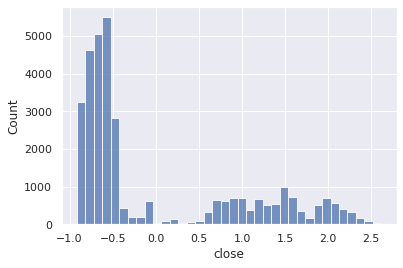

In [49]:
sns.histplot(data=dx, x=dx['close'], stat='count')

<AxesSubplot:xlabel='open', ylabel='Count'>

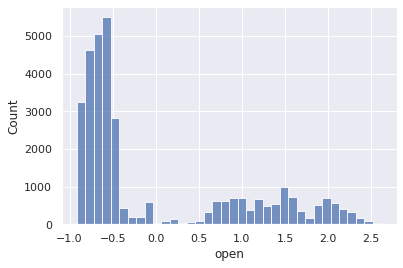

In [50]:
sns.histplot(data=dx, x=dx['open'], stat='count')

<AxesSubplot:xlabel='high', ylabel='Count'>

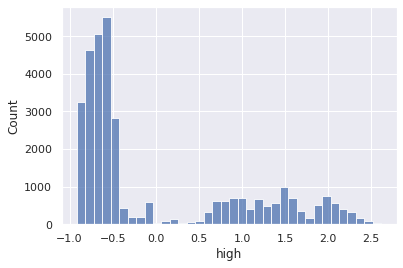

In [51]:
sns.histplot(data=dx, x=dx['high'], stat='count')

<AxesSubplot:xlabel='low', ylabel='Count'>

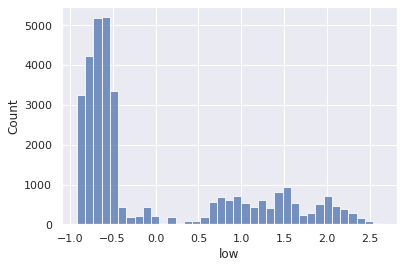

In [52]:
sns.histplot(data=dx, x=dx['low'], stat='count')

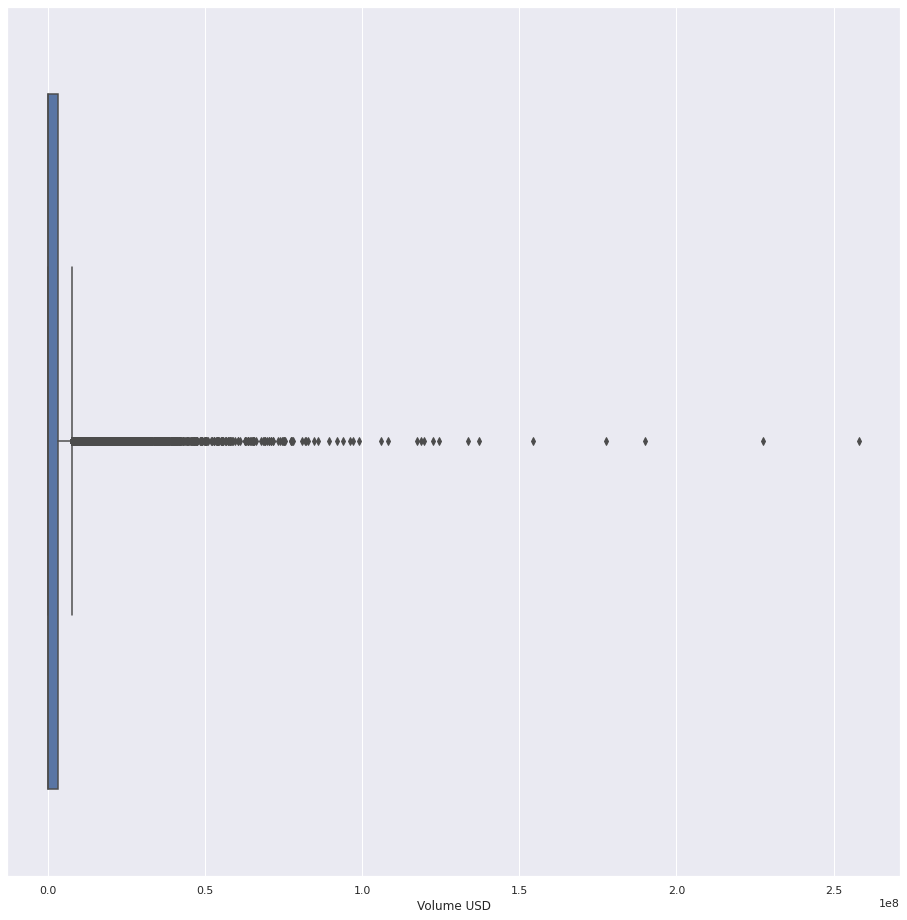

In [53]:
plt.figure(figsize=(16,16))
sns.boxplot(data=df, x=df['Volume USD'])
plt.show()

* The values for the Open, High, Low and Close all seem to have similar distributions and positive skewness.
* No values from the Open, High, Low and Close fall more than 3 std from the mean, and were reported at a confidence interval of 97.4%.
* The Volumes both have extreme outliers. They are positively skewed.

# Bivariate Analysis
* Determining the correlations of the features with the targets. High correlation may indicate a relationship which, could indicate that they are good candidates as features for the models.

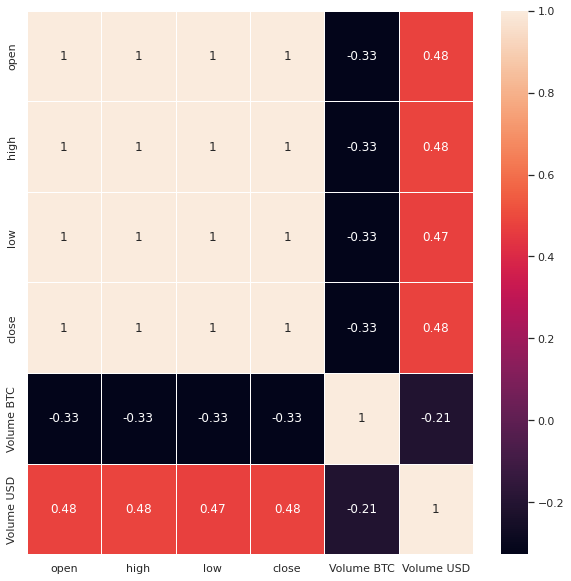

In [54]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, linewidth=0.5)
plt.show()

* Seems like there is high correlations of the High,Open and Low with the Close. ( Might need a PCA )
* There seems to be a low negative correlation between the close and the Volume BTC ( Needs more research )
* The Volume USD seems to have a moderate correlation to the target (Close).

# Principal Component Analysis
* Remove multicolinearity among the High,Low and Open, features.
* Decorrelate the High,Low and Open, features with the Close (Target).

In [55]:
features = df[['high','open','low','close']]
features =  (features - features.mean(axis=0)) / features.std(axis=0)

scaler = MinMaxScaler()

pca = PCA()
features_pca = pca.fit_transform(features)

component_names = [f"PC{i+1}" for i in range(features_pca.shape[1])]
features_pca = pd.DataFrame(features_pca, columns=component_names)

features_pca.head()

,PC1,PC2,PC3,PC4
0,-1.227229,-0.000425,0.000175,0.000844
1,-1.227538,-0.001851,-0.000644,0.000049
2,-1.229941,0.000136,-0.000488,-0.001406
3,-1.229550,-0.001402,-0.001215,0.000443
4,-1.224936,0.001523,0.003989,0.001806


In [56]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=features.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
high,0.500001,0.597680,0.205314,0.592135
open,0.500000,0.269775,-0.684198,-0.457268
low,0.499997,-0.744983,-0.193605,0.396889
close,0.500002,-0.122478,0.672485,-0.531752


* The High, Open and close values played an important role in seperating the clusters. Which indicates that the most variance in the data came from these variables.


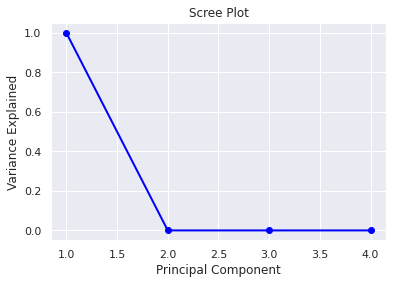

[1. 0. 0. 0.]


In [57]:
import matplotlib.pyplot as plt
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print(np.round(pca.explained_variance_ratio_))


* PC1 makes up all of the variance in the data set the specific variation was around 99 %.
* This means that a combination of the Open, High and Close manage to capture the pattern in the data well.

In [58]:
dx = df.copy()
dx = dx.reset_index()
dx = dx.join(features_pca)


# Selecting the Best Features from the Dataset 
* Done using a RandomForest Regressor and Entrophy method.
* Lower entrophy better.

In [59]:
features_x = dx.drop(['date','close'], axis=1)
target = dx.pop('close')

d_features = features_x.dtypes == int

mi_scores = mutual_info_regression(features_x, target, discrete_features=d_features)
mi_scores =  pd.Series(mi_scores, name="MI Scores", index=features_x.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores

PC1           5.137962
high          5.013266
low           4.946313
open          4.429229
Volume USD    0.713209
Volume BTC    0.679845
PC2           0.601429
PC3           0.396119
PC4           0.334677
Name: MI Scores, dtype: float64

In [60]:
mis = mi_scores.to_frame()
mis

,MI Scores
PC1,5.137962
high,5.013266
low,4.946313
open,4.429229
Volume USD,0.713209
Volume BTC,0.679845
PC2,0.601429
PC3,0.396119
PC4,0.334677


<AxesSubplot:xlabel='MI Scores'>

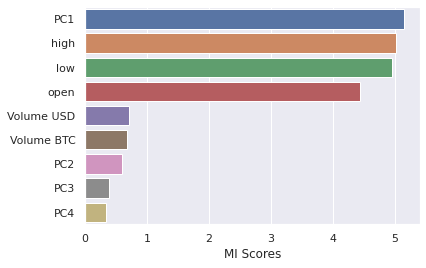

In [61]:
sns.barplot(data=mis, x=mis['MI Scores'], y=mis.index)

**Only taking the Top 3 features with the highest information gain.**
* PC1
* High
* Low

* By theory PC1 should be enough to help the model learn the pattern. But follwing best practices to improve accuracy of a model it should be fitted with more that one variable. So, the top 3 variables with the most information gain is used.

# Building the LSTM Model

In [62]:
#Preparing the data ( Remove all unwanted features)
btc_features = dx[['PC1', 'high', 'low']]
btc_target = target

btc_dates =  dx.pop('date')

# Feature Scaler 
f_scaler = MinMaxScaler()

# Target Scaler
t_scaler = MinMaxScaler() # The t_scaler will be used to insverse the transformation of 1-D data later ( output ). This is because the scalers are only able to transform data back to their original values based on the fitted dimension.

# Convert to numpy Array
btc_features = btc_features.to_numpy()
btc_target = btc_target.to_numpy()
btc_dates = btc_dates.to_numpy()
# Normalize
btc_features = f_scaler.fit_transform(btc_features)
btc_target = t_scaler.fit_transform(btc_target.reshape(-1,1))

print(btc_dates)

['2018-05-15T06:00:00.000000000' '2018-05-15T07:00:00.000000000'
 '2018-05-15T08:00:00.000000000' ... '2022-02-28T22:00:00.000000000'
 '2022-02-28T23:00:00.000000000' '2022-03-01T00:00:00.000000000']


In [63]:
# Using for loops to reshape the data to a 24-hour rolling window. The logic behind this is to use data from the previous 24-hrs to predict the 25th hour.
x = [] # The features needed for prediction.
y = [] # The expected result.

date = []
y_date = []

for i in range(len(btc_features)-24):
    x.append(btc_features[i:i+24])

for i in range(len(btc_target)-24):
        y.append(btc_target[i])
        
# Used to verify if batches are indeed shuffled by batch and not by row.       
"""
for i in range(len(btc_dates)-24):
    date.append(btc_dates[i:i+24])
    
for i in range(len(btc_dates)-24):
        y_date.append(btc_dates[i])
"""

'\nfor i in range(len(btc_dates)-24):\n    date.append(btc_dates[i:i+24])\n    \nfor i in range(len(btc_dates)-24):\n        y_date.append(btc_dates[i])\n'

In [64]:
# Validating that the data is in 3-Dimenstions. Neural-Networks need 3-D data.
X = np.array(x)
Y = np.array(y)
Date = np.array(date)
Y_date = np.array(y_date)

print(X.shape)
print(Y.shape)

# Used to verify if batches are indeed shuffled by batch and not by row. 
# print(Date.shape)
# print(Y_date.shape)

(33230, 24, 3)
(33230, 1)


In [65]:
# Spliting the data to 80% training and 20% testing. By hyperparameter tuning the training data will be 70% and 10% will be reserved for validation.
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True) # Conduct batch shuffling

# Used to verify if batches are indeed shuffled by batch and not by row.   
#D_train, d_test, YD_train, yd_test = train_test_split(Date, Y_date, test_size=0.2, shuffle=True) # Conduct batch shuffling

print(X_train.shape)
print(Y_train.shape)
print(x_test.shape)
print(y_test.shape)
"""
print("-----------------")
print(D_train.shape)
print(YD_train.shape)
print(d_test.shape)
print(yd_test.shape)
"""

(26584, 24, 3)
(26584, 1)
(6646, 24, 3)
(6646, 1)


'\nprint("-----------------")\nprint(D_train.shape)\nprint(YD_train.shape)\nprint(d_test.shape)\nprint(yd_test.shape)\n'

In [66]:
# Used to verify if batches are indeed shuffled by batch and not by row.
# print(D_train)
# print(YD_train)

* Cypto data has high noise due to the volatility of crypto currencies, hence the dropout feature is used.
* Regularization process of dropout makes the neurons independent of each other so that all of them can perform better with less noise.

In [67]:
model = Sequential()
model.add(LSTM(400, return_sequences=True, input_shape=(24,3)))
model.add(LSTM(350, return_sequences=True, dropout=0.5)) # Dropout of 0.5 determined trough trial and error.
model.add(LSTM(300, return_sequences=True, dropout=0.5))
model.add(LSTM(350, return_sequences=True, dropout=0.5))
model.add(LSTM(200, return_sequences=True, dropout=0.5))
model.add(LSTM(350, return_sequences=True, dropout=0.5))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation='relu'))    # ReLu is used as the data has a linear trend ( Based on the residual plot of the target)
model.add(Dense(20,  activation='relu'))
model.add(Dense(15,  activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5,  activation='relu'))
model.add(Dense(1))

In [68]:
#  Early stopping callback used to prevent overfitting.
early_stopping = EarlyStopping(
    patience=5, # Minimum cycles of no signal learnt by the model to stop the learning process.
    min_delta=0.001, # Minimum learning required to continue.
    verbose=1, # Debug messages set to True
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity. 
)

In [69]:
model.compile(optimizer='adam', loss='mae', metrics=['mean_absolute_percentage_error'] ) # Compiling using the Stohastic Gradient Decsent algorithm, Adam and loss montoring function of Mean Absolute Error as the model is performing a regression.

In [70]:
history = model.fit(X_train, Y_train, batch_size=2000, epochs=15, callbacks=early_stopping, validation_split=0.1, verbose=0)

* **Batch Size and Epoch determined by trial and error by evaluating training and validation loss**

Minimum Validation Loss: 0.0054


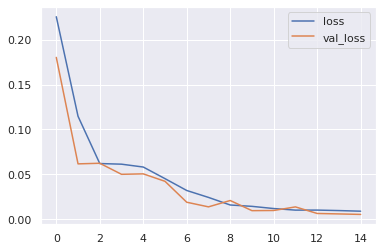

In [71]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [72]:
prediction = model.predict(x_test)

In [73]:
prediction = t_scaler.inverse_transform(prediction) # Inversing the predictions from the normalized values
actual = t_scaler.inverse_transform(y_test)

In [74]:
prediction.shape

(6646, 1)

In [75]:
prediction_df = pd.DataFrame(prediction, columns=['y_hat']) # Creating a dataframe to evaluate the performance

In [76]:
prediction_df['close'] = actual

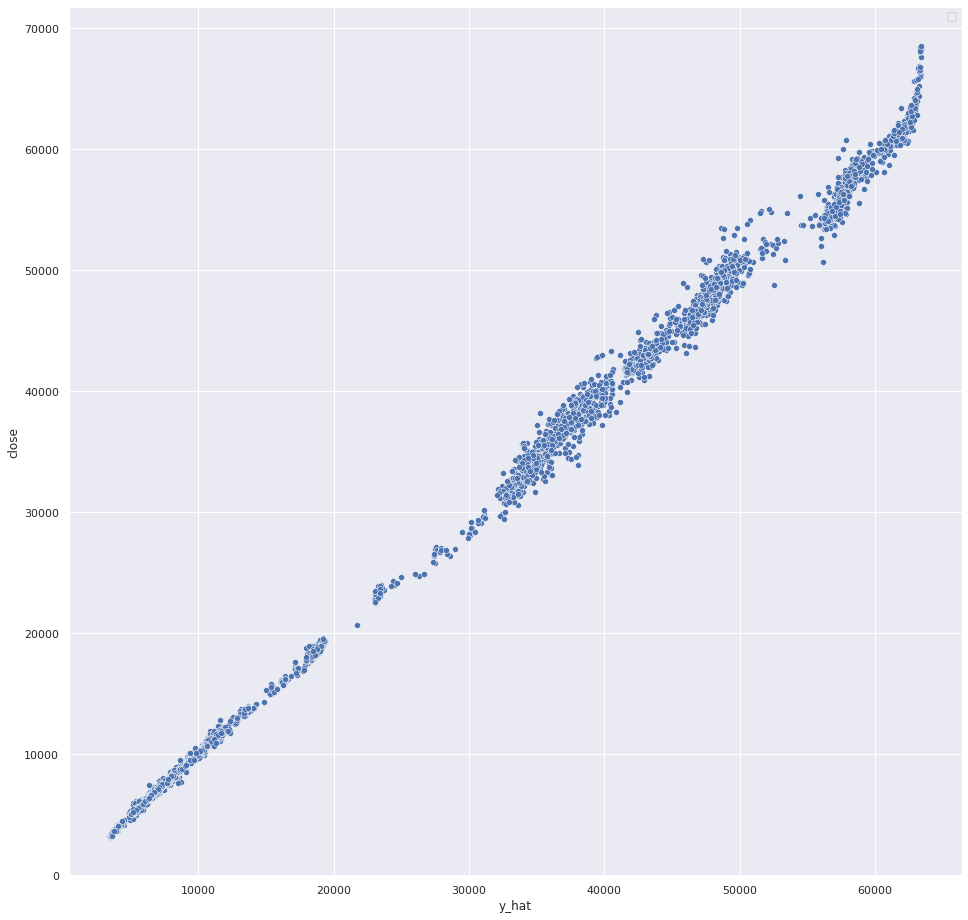

In [77]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=prediction_df, x=prediction_df['y_hat'], y=prediction_df['close'])
plt.legend()
plt.show()

In [78]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('MAPE:', round(score[1],2), '%')

208/208 [==============================] - 2s 9ms/step - loss: 0.0056 - mean_absolute_percentage_error: 5.6696
Test loss: 0.005639354698359966
MAPE: 5.67 %
